Experimental dataset to create regression models of appliances energy use in a low energy building. LSTM RNN to predict usage.
	

In [1]:
from math import sqrt
from sklearn.cross_validation import train_test_split
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import to_datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from matplotlib import pyplot


/home/bhushan/anaconda3/envs/SmartOff/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [76]:
# convert series to supervised learning
def series_to_supervised(dataset, n_in=1, n_out=1, dropnan=True):
    num_vars = 1 if type(dataset) is list else dataset.shape[1]
    dataframe = DataFrame(dataset)
    cols, names = list(), list()
    
    # input sequence (t-n, ....t-1)
    for i in range(n_in, 0, -1):
        cols.append(dataframe.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_vars)]
    # forecast sequence (t, t+1 .... t+n)
    for i in range(0, n_out):
        cols.append(dataframe.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_vars)]
    
    # put it all together 
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [81]:
#import os
#!ls ../input
#dataset1 = read_csv('../input/appliances-energy-prediction/KAG_energydata_complete.csv')
dataset = read_csv('./data/house5/channel_5TV.dat', sep=' ', names=['Date', 'Usage'])
#dataset = datasetFull[:10000]
values = dataset.values
print(type(dataset['Date'][0]), type(dataset['Usage'][0]))
print(len(dataset))
print(values[:10])
print(type(values[0][0]), type(values[0][0]))
print(values.shape)
#values = values[:100,:]

<class 'numpy.int64'> <class 'numpy.int64'>
1840507
[[1404059032         69]
 [1404059038         69]
 [1404059044         69]
 [1404059050         69]
 [1404059056         69]
 [1404059062         68]
 [1404059068         68]
 [1404059074         69]
 [1404059080         68]
 [1404059086         68]]
<class 'numpy.int64'> <class 'numpy.int64'>
(1840507, 2)


In [24]:
values[:,0] = to_datetime(values[:,0])
print(type(values[0][0]), type(values[0][1]))
print(values[:10])

<class 'numpy.int64'> <class 'numpy.int64'>
[[1404059032         69]
 [1404059038         69]
 [1404059044         69]
 [1404059050         69]
 [1404059056         69]
 [1404059062         68]
 [1404059068         68]
 [1404059074         69]
 [1404059080         68]
 [1404059086         68]]


In [85]:
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
print(scaled[:10])

[[  0.00000000e+00   4.14663462e-02]
 [  5.06656420e-07   4.14663462e-02]
 [  1.01331283e-06   4.14663462e-02]
 [  1.51996923e-06   4.14663462e-02]
 [  2.02662565e-06   4.14663462e-02]
 [  2.53328206e-06   4.08653846e-02]
 [  3.03993846e-06   4.08653846e-02]
 [  3.54659487e-06   4.14663462e-02]
 [  4.05325129e-06   4.08653846e-02]
 [  4.55990769e-06   4.08653846e-02]]


/home/bhushan/anaconda3/envs/SmartOff/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [86]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
#reframed.drop(reframed.columns[[29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57]], axis=1, inplace=True)
print("reframed: ", reframed.shape, "reframed head: ", reframed.head())

# split into train and test sets
values = reframed.values
print(values.shape)
X = values[:,:1]
Y = values[:,1]
#Y2 = dataset[:,16]  
print(X.shape)
print(Y.shape)
print(values[:10])
# Split Data to Train and Test
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.3)

# reshape input to be 3D [samples, timesteps, features]
X_Train = X_Train.reshape((X_Train.shape[0], 1, X_Train.shape[1]))
X_Test = X_Test.reshape((X_Test.shape[0], 1, X_Test.shape[1]))

reframed:  (1840506, 4) reframed head:        var1(t-1)  var2(t-1)       var1(t)   var2(t)
1  0.000000e+00   0.041466  5.066564e-07  0.041466
2  5.066564e-07   0.041466  1.013313e-06  0.041466
3  1.013313e-06   0.041466  1.519969e-06  0.041466
4  1.519969e-06   0.041466  2.026626e-06  0.041466
5  2.026626e-06   0.041466  2.533282e-06  0.040865
(1840506, 4)
(1840506, 1)
(1840506,)
[[  0.00000000e+00   4.14663462e-02   5.06656420e-07   4.14663462e-02]
 [  5.06656420e-07   4.14663462e-02   1.01331283e-06   4.14663462e-02]
 [  1.01331283e-06   4.14663462e-02   1.51996923e-06   4.14663462e-02]
 [  1.51996923e-06   4.14663462e-02   2.02662565e-06   4.14663462e-02]
 [  2.02662565e-06   4.14663462e-02   2.53328206e-06   4.08653846e-02]
 [  2.53328206e-06   4.08653846e-02   3.03993846e-06   4.08653846e-02]
 [  3.03993846e-06   4.08653846e-02   3.54659487e-06   4.14663462e-02]
 [  3.54659487e-06   4.14663462e-02   4.05325129e-06   4.08653846e-02]
 [  4.05325129e-06   4.08653846e-02   4.55990769e

In [89]:
# network architecture
model = Sequential()
model.add(LSTM(50, input_shape=(X_Train.shape[1], X_Train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit
history = model.fit(X_Train, Y_Train, epochs=10, batch_size=10, validation_data=(X_Test, Y_Test), verbose=2, shuffle=False)

Train on 1288354 samples, validate on 552152 samples
Epoch 1/10
386s - loss: 1.3387e-04 - val_loss: 1.3112e-04
Epoch 2/10
389s - loss: 1.3238e-04 - val_loss: 1.2918e-04
Epoch 3/10
398s - loss: 1.3128e-04 - val_loss: 1.2916e-04
Epoch 4/10
367s - loss: 1.3120e-04 - val_loss: 1.2918e-04
Epoch 5/10
367s - loss: 1.3115e-04 - val_loss: 1.2918e-04
Epoch 6/10
390s - loss: 1.3110e-04 - val_loss: 1.2914e-04
Epoch 7/10
402s - loss: 1.3106e-04 - val_loss: 1.2913e-04
Epoch 8/10
385s - loss: 1.3099e-04 - val_loss: 1.2911e-04
Epoch 9/10
370s - loss: 1.3090e-04 - val_loss: 1.2905e-04
Epoch 10/10
392s - loss: 1.3081e-04 - val_loss: 1.2904e-04


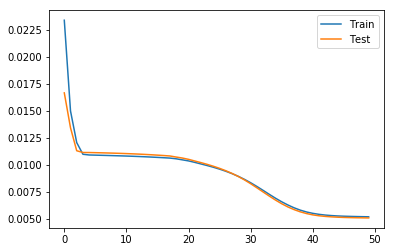

In [19]:
# plot history

pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Test')
pyplot.legend()
pyplot.show()

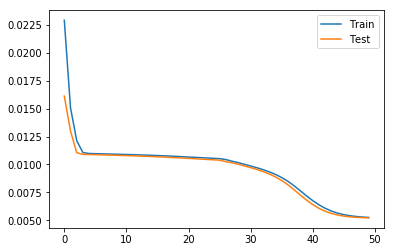

In [27]:
pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Test')
pyplot.legend()
pyplot.show()

In [28]:
print(history)

In [69]:
prediction = model.predict(X_Test)
Y_Test = Y_Test.reshape(3000,-1)
print(prediction.shape)
print(Y_Test1.shape, Y_Test.shape)

(3000, 1)
(3000, 1) (3000, 1)


In [73]:
Diff = Y_Test - prediction

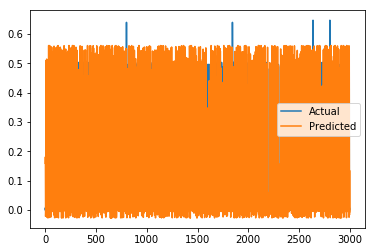

In [71]:
pyplot.plot(Y_Test, label='Actual')
pyplot.plot(prediction, label='Predicted')
pyplot.legend()
pyplot.show()

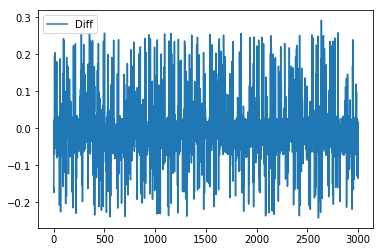

In [72]:
pyplot.plot(Diff, label='Diff')
pyplot.legend()
pyplot.show()

In [74]:
print(mean_squared_error(Y_Test, prediction))

0.00520228189842


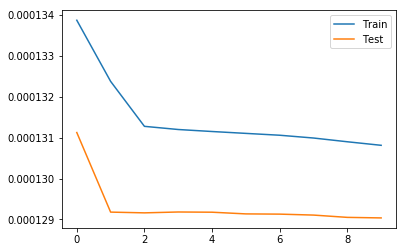

In [90]:
pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Test')
pyplot.legend()
pyplot.show()

In [104]:
prediction = model.predict(X_Test)

In [99]:
Y_Test = Y_Test.reshape(Y_Test.shape[0],-1)

In [100]:
Diff = Y_Test - prediction

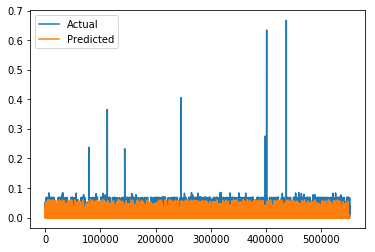

In [101]:
pyplot.plot(Y_Test, label='Actual')
pyplot.plot(prediction, label='Predicted')
pyplot.legend()
pyplot.show()

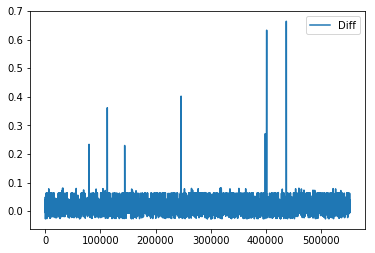

In [102]:
pyplot.plot(Diff, label='Diff')
pyplot.legend()
pyplot.show()

In [103]:
print(mean_squared_error(Y_Test, prediction))

0.000129037328663


In [105]:
print(Y_Test.shape)

(552152, 1)


In [106]:
print(X_Train.shape)

(1288354, 1, 1)
